## Define and find local maxima-clusters. Find associations (clusters, groups, NGC galaxies)

In this notebook I find local maxima in the distribution of the LSBGs (clusters) and associate these maxima with galaxy clusters, galaxy groups, and NGC galaxies.

In [2]:
#Import stuff
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
#import seaborn as sns
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    # if you have LaTeX installed on your laptop, uncomment the line below for prettier labels
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

In [3]:
import healpy as hp
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from sklearn.neighbors import KernelDensity
import pandas as pd

LSBG_df = pd.read_csv('LSBG_sample.csv')

### Part I: Kernel Density Estimation of the overdensity field

In [4]:
# Import the coordinates of the LSBGs objects
# Polygon
ra_DES, dec_DES = np.loadtxt("DES_polygon.dat", usecols=(0,1), unpack=3)

LSBG_df = pd.read_csv('LSBG_sample.csv')

ra = LSBG_df['RA'].values
dec = LSBG_df['DEC'].values
for i in range(len(ra)):
    if (ra[i] > 150.):
        ra[i] = ra[i]-360.
        
latlon = np.vstack([dec,ra]).T

In [5]:
# Import the Healpix footprint
MAP = hp.read_map('y3a2_footprint_grizY_any.fits')

NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [6]:
x_min = -70.; x_max = 110.
y_min = - 70; y_max = 10.
# ============================
# Define the aspect ratio
asp_rat = (x_max-x_min)/(y_max - y_min)
base_points = 400
y_points = base_points
x_points = int(asp_rat*base_points)

In [7]:
# Create a grid of positions over which we are going to calculate the KDE
x_grid = np.linspace(x_min,x_max,x_points)
y_grid = np.linspace(y_min,y_max,y_points)

X, Y = np.meshgrid(x_grid,y_grid)
xy = np.vstack([Y.ravel(),X.ravel()]).T

Now keep only those points that are within the DES footprint.

In [8]:
# Get a mask - 1 inside the DES mask
DES_mask = np.zeros(len(MAP))
DES_mask[MAP>0] = 1 

In [9]:
# Get the healpix indices xy points
HP_ind = hp.ang2pix(4096, xy[:,1], xy[:,0], lonlat=True)
xy = np.radians(xy)

In [10]:
# Keep only those with randoms for which the value of the des mask 
# ===============================================
# ===============================================
# Keep local mask
LOCAL_mask = DES_mask[HP_ind]

ra_loc = xy[:,1]
dec_loc = xy[:,0]

# Keep those with LOCAL_mask = 1
ra_pos = ra_loc[LOCAL_mask==1]
dec_pos = dec_loc[LOCAL_mask==1]

#land_mask = np.vstack()
land_mask = xy[LOCAL_mask==1]

Now, fit our KDE 

In [11]:
kern_size = 0.0052  # This kernel size corresponds to 0.3 deg in radians
# Fit now 
kde = KernelDensity(bandwidth=kern_size, kernel='gaussian', metric='haversine')
kde.fit(np.radians(latlon))

KernelDensity(algorithm='auto', atol=0, bandwidth=0.0052, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='haversine',
       metric_params=None, rtol=0)

In [12]:
# Evaluate on the xy map 
Z = np.exp(kde.score_samples(xy))
Z[LOCAL_mask==0] = 0
Z = Z.reshape(X.shape)

#### 5 sigma clipping

- Write my own function that performs 5-sigma clipping

In [13]:
def five_sigma_clip(X_arr, iters):
    X_old = X_arr
    for i in range(iters):
        low = np.mean(X_old) - 5.0*np.std(X_old)
        up = np.mean(X_old) + 5.0*np.std(X_old)
        X_new = X_old[(X_old>low)&(X_old<up)]
        X_old = np.copy(X_new)
        
    return X_old, low, up

In [14]:
#from astropy.stats import sigma_clip
from scipy.stats import sigmaclip as sigma_clip
Z_rav = Z.ravel()
Z_for_clip = Z_rav[Z_rav>0]
# ===================================================================
# ===================================================================
#filt_z_3sigma, low_3sigma, up_3sigma = sigma_clip(Z_for_clip, sigma=3, maxiters=12,return_bounds=True) 
#filt_z_4sigma, low_4sigma, up_4sigma = sigma_clip(Z_for_clip, sigma=4, maxiters=12,return_bounds=True) 
filt_z_5sigma, low_5sigma, up_5sigma = sigma_clip(Z_for_clip, low=5.0, high=5.0) 
print(up_5sigma)
filt_z_5sigma, low_5sigma, up_5sigma = five_sigma_clip(Z_for_clip, 15) 
print(up_5sigma)

2.594315277244625
2.594315277244625


In [15]:
from scipy.stats import gaussian_kde
#Fit kernel
kernel = gaussian_kde(Z_for_clip)
# Evaluate in a number of points ane plot to see
kde_points_eval  = np.linspace(-1.0,4.0,200)
kde_val =  kernel(kde_points_eval)

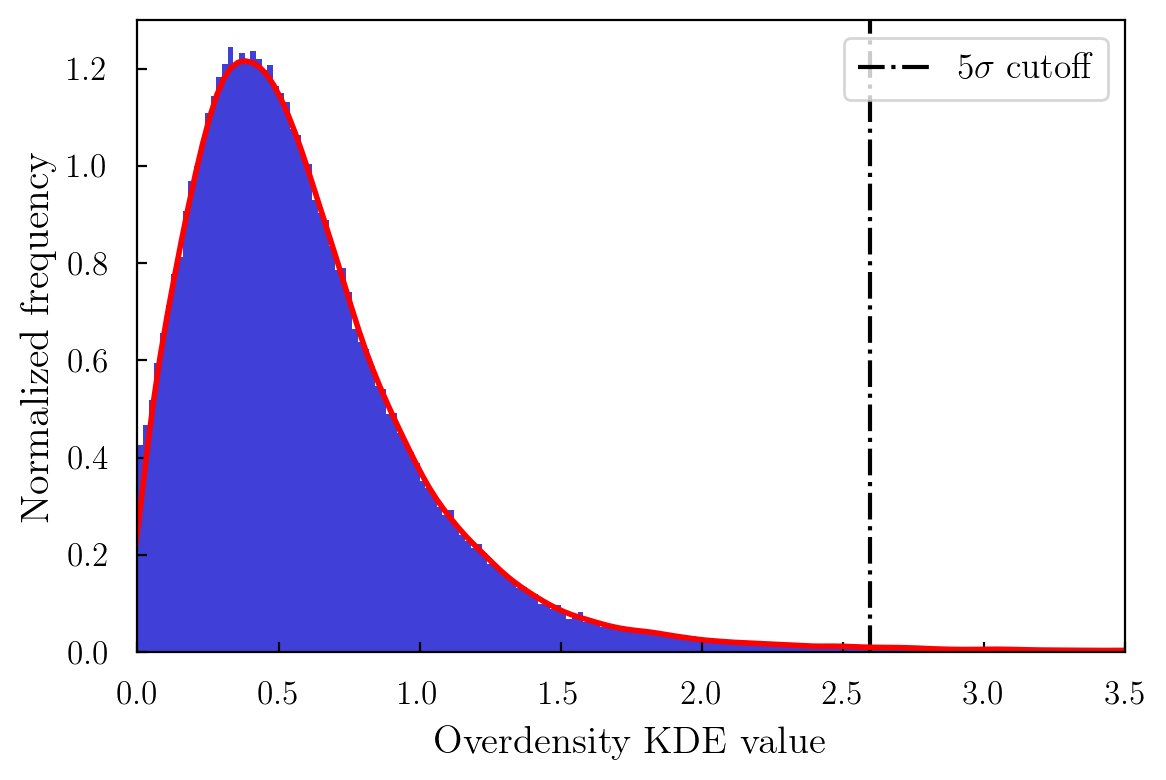

In [16]:
plt.figure(figsize = (5.91,4.0))

#plt.plot(kde_points_eval,kde_val, c='red', label='kde')
plt.hist(Z_for_clip,range=[0,4], bins=200, color='mediumblue', density=True, alpha=0.75)
plt.plot(kde_points_eval,kde_val, c='red', linewidth=2)

#plt.hist(filt_z_5sigma ,density=True)
#plt.vlines(up_3sigma,0,1.3, color='k', linestyle=':',label='3$\sigma$ cutoff')
#plt.vlines(up_4sigma,0,1.3, color='k', linestyle='--',label='4$\sigma$ cutoff')
plt.vlines(up_5sigma,0,1.3, color='k', linestyle='-.',label='5$\sigma$ cutoff')


# ===================================================================
plt.legend(loc='upper right', frameon=True, fontsize=12.8)
plt.xlim(-0.,3.5);plt.ylim(0,1.3)
plt.xlabel('Overdensity KDE value', fontsize=14);plt.ylabel('Normalized frequency', fontsize=14.5)
plt.tick_params(axis='both', labelsize=12)

plt.tight_layout()
#plt.savefig('Hist_clipping.pdf', dpi=300)
plt.show()

### Find and plot the 5 $\sigma$ maxima

In [17]:
from skimage.feature import peak_local_max
# ========================================
# ========================================
# Find the peaks that lie 5 sigma above the mean
xy_5sigma = peak_local_max(Z, min_distance=1,threshold_abs=up_5sigma)
# Print its size
print(np.shape(xy_5sigma)[0])

88


In [18]:
# Get their ra and dec
# For the 5 sigma points now
ra_s_like = xy_5sigma[:,1];dec_s_like = xy_5sigma[:,0]
ra_max_5sigma = x_grid[ra_s_like];dec_max_5sigma = y_grid[dec_s_like]
ra_5s = ra_max_5sigma;dec_5s = dec_max_5sigma 
np.savetxt('Peaks_coords.dat', np.c_[ra_5s, dec_5s], fmt='%.6f %.6f ')

//anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'rasterized'
  s)


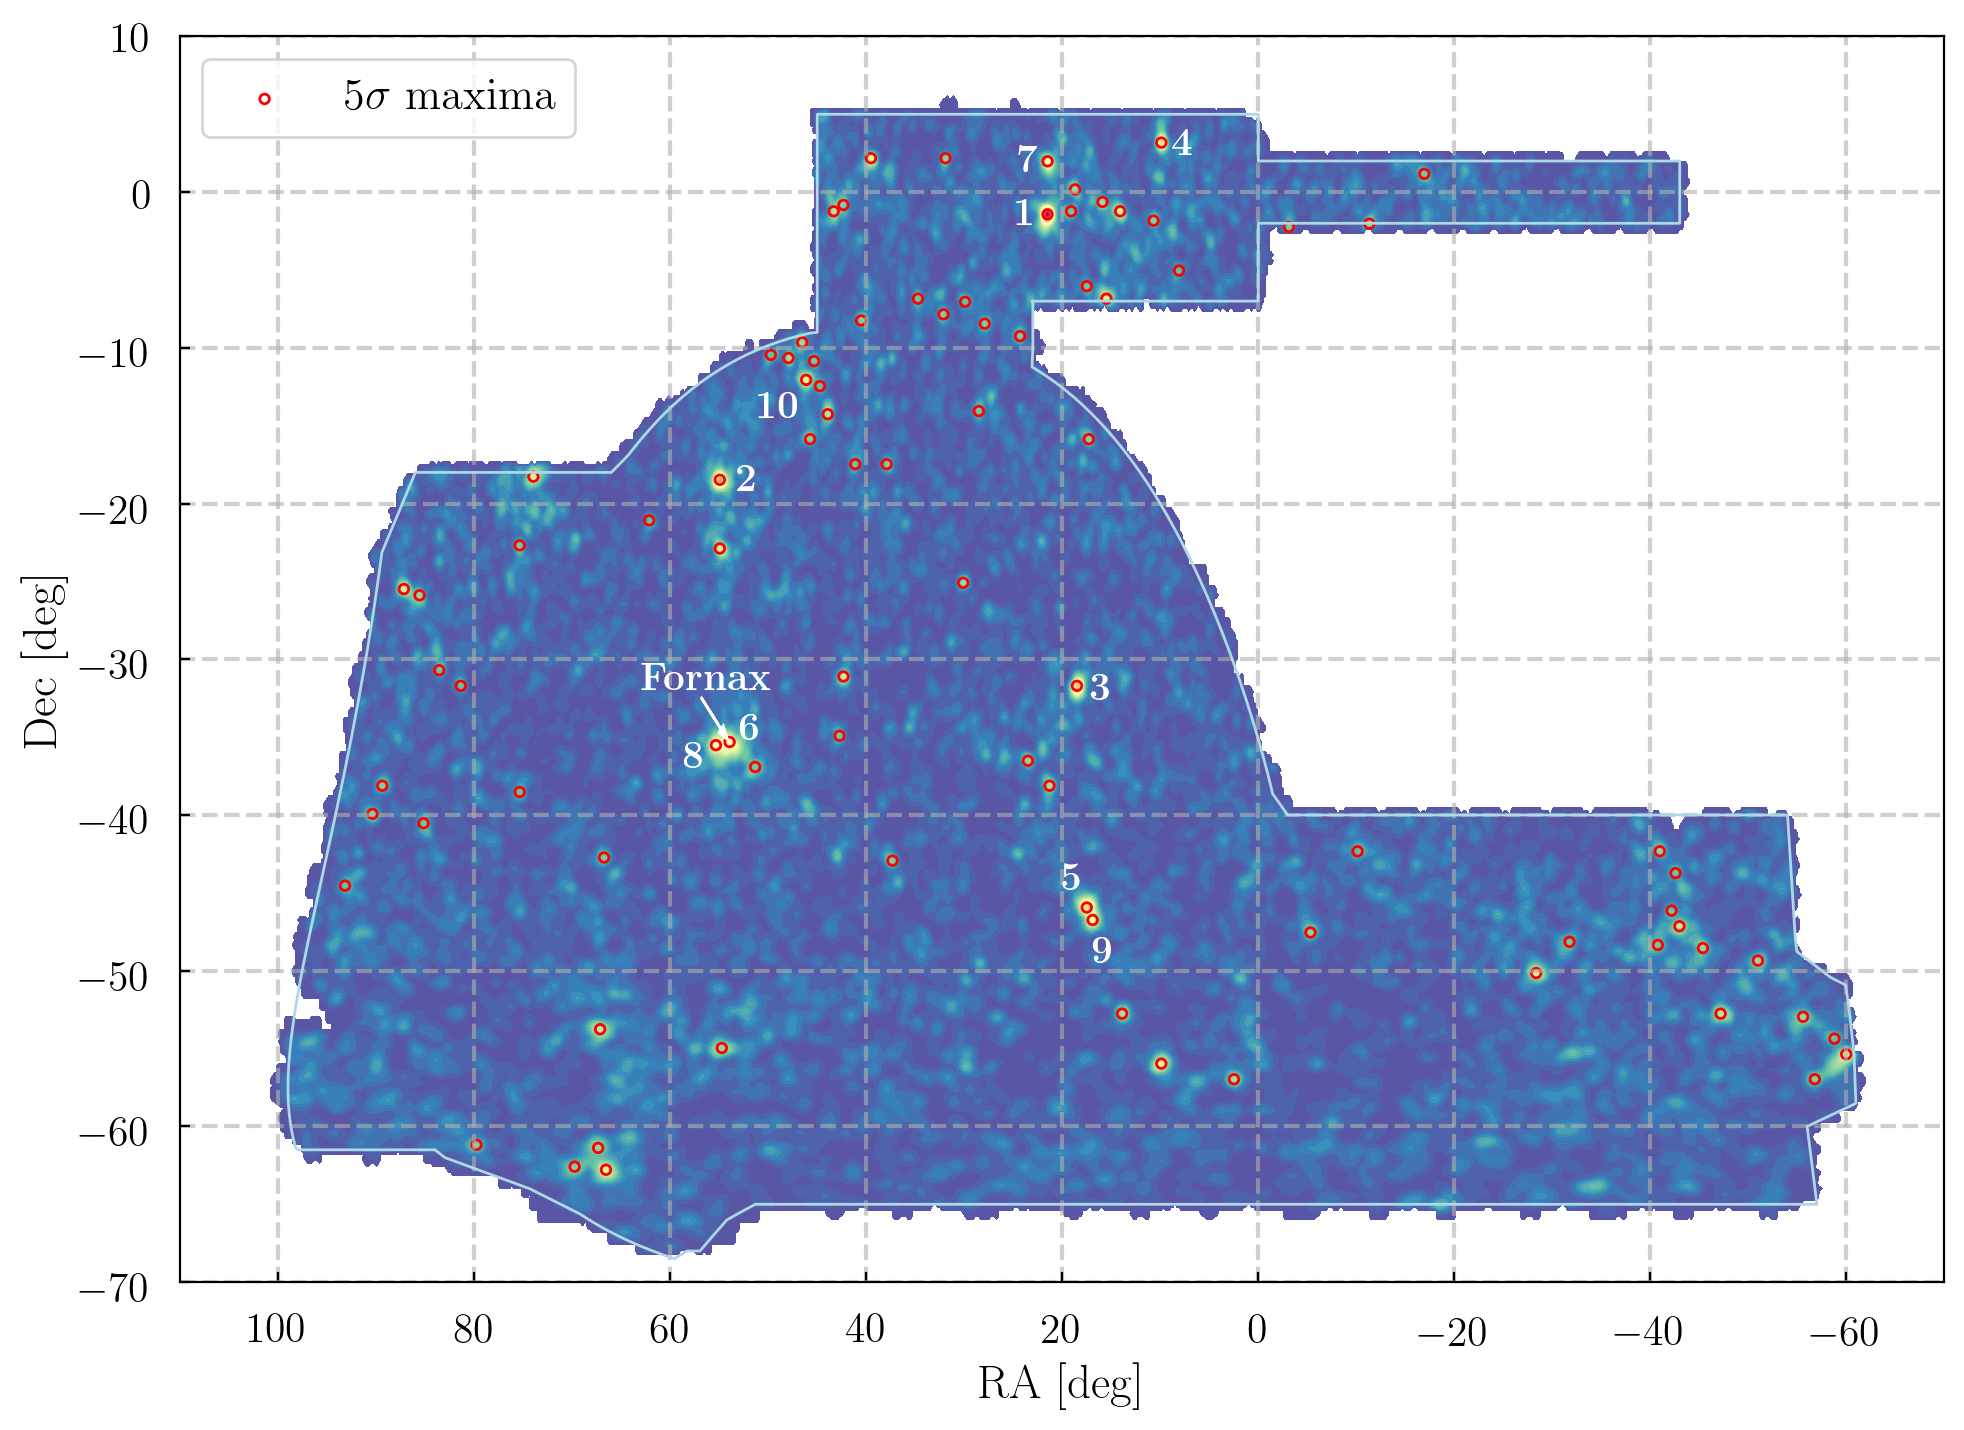

In [19]:
plt.figure(figsize = (0.9*11.0,0.9*8.0))

levels = np.linspace(1e-6, Z.max(),40)

plt.plot(ra_DES, dec_DES, c='lightblue', linewidth=1.0)
plt.contourf(X,Y,Z, levels=levels,rasterized=True, cmap='Spectral_r')

plt.scatter(ra_5s, dec_5s, s=12,facecolors='none', edgecolors='r', label='$5\sigma$ maxima')


# ================================================================
# Put names 
plt.text(24.7,-2.1,r'\textbf{1}',color='w', fontsize=14)
plt.text(53.2,-19.2,r'\textbf{2}',color='w', fontsize=14)
plt.text(17.2,-32.6,r'\textbf{3}',color='w', fontsize=14)
plt.text(8.8,2.3,r'\textbf{4}',color='w', fontsize=14)
plt.text(20,-44.8,r'\textbf{5}',color='w', fontsize=14)
plt.text(53.,-35.2,r'\textbf{6}',color='w', fontsize=14)
plt.text(24.5,1.3,r'\textbf{7}',color='w', fontsize=14)
plt.text(58.7,-37.0,r'\textbf{8}',color='w', fontsize=14)
plt.text(17,-49.5,r'\textbf{9}',color='w', fontsize=14)
plt.text(51,-14.5,r'\textbf{10}',color='w', fontsize=14)

plt.text(63,-32,r'\textbf{Fornax}',color='w', fontsize=14)
plt.arrow(56.8,-32.5,-2,-2,color='w',head_width=0.6)
# ===============================================================
plt.xlim(110,-70);plt.ylim(-70,10)
plt.xlabel('RA [deg]',fontsize=17);plt.ylabel('Dec [deg]', fontsize=17.5)
plt.legend(loc='upper left', frameon=True, fontsize=16)

plt.grid(ls='--', axis='both' ,alpha=0.6,linewidth=1.5)
plt.tick_params(axis='both', labelsize=15)

plt.tight_layout()
#plt.savefig('KDE_peaks.pdf', dpi=300)
plt.show()

In [21]:
import skymap as smap
from skymap import DESSkymap

In [22]:
# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    # if you have LaTeX installed on your laptop, uncomment the line below for prettier labels
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=1.6*fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

skymap/mpl_toolkits/basemap/__init__.py:4749: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if fix_wrap_around and itemindex:


may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).

//anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/cbook/__init__.py:2448: UserWarning: Saw kwargs [u'lw', u'linewidth'] which are all aliases for u'linewidth'.  Kept value from u'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
//anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


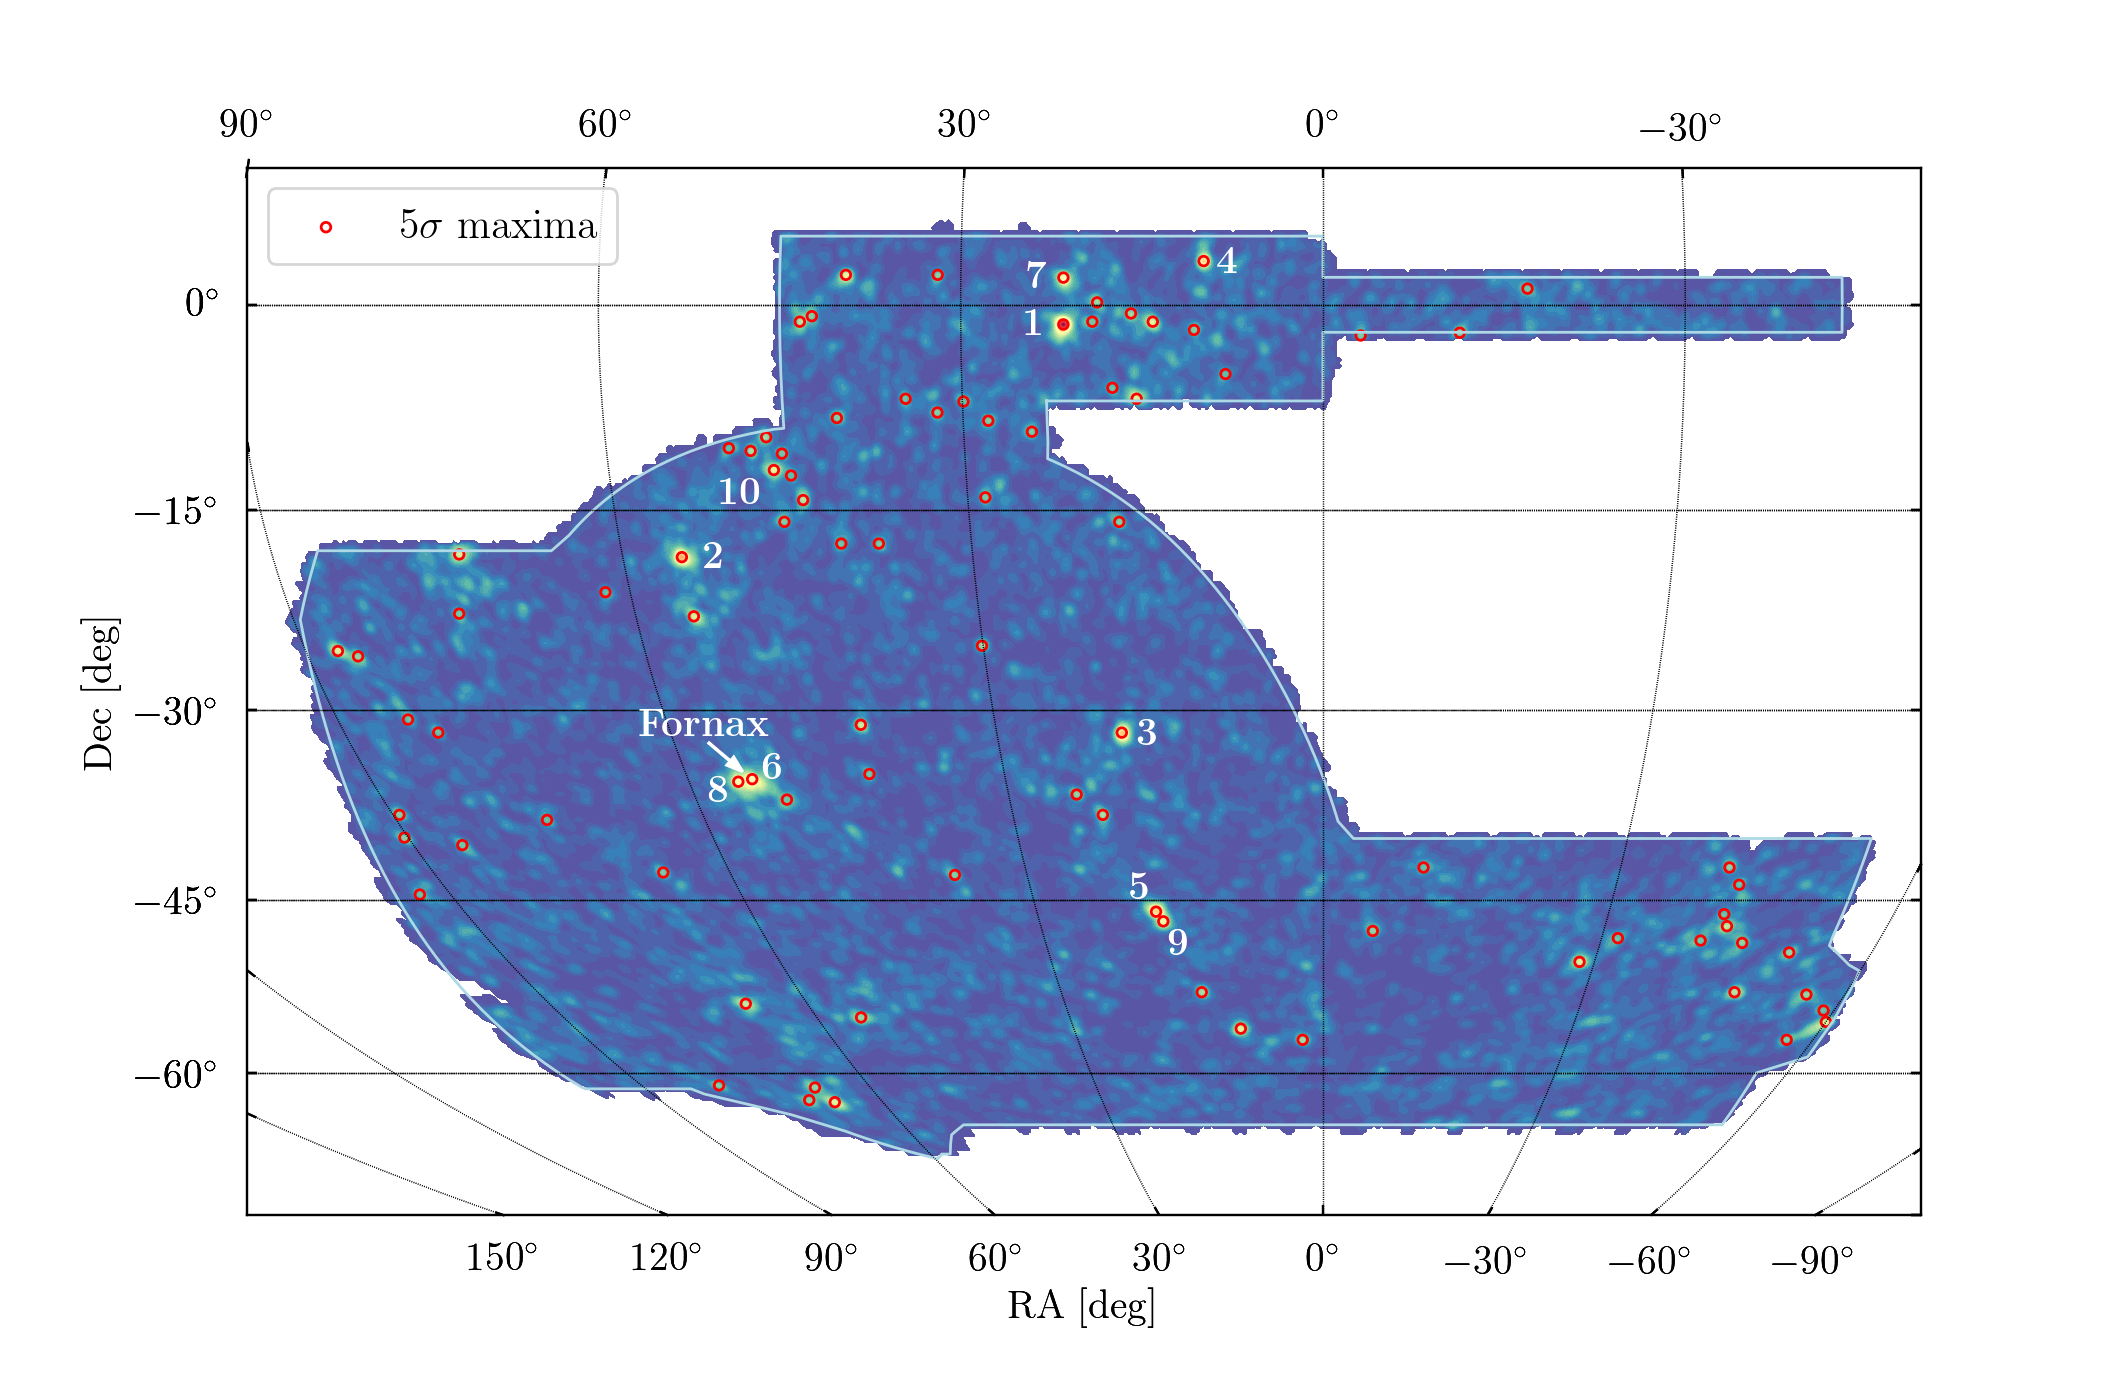

In [23]:
plt.figure(figsize = (0.9*12.0,0.9*8.0))

smap = DESSkymap()

# ================================================================
# Put names 
plt.text(2.540938504519237, 1.2865569654111808,r'\textbf{1}',color='w', fontsize=14)
plt.text(2.1062015247704826, 0.970531782210,r'\textbf{2}',color='w', fontsize=14)
plt.text(2.6931219940795184, 0.73035200028980,r'\textbf{3}',color='w', fontsize=14)
plt.text(2.8009674499011963, 1.3684745078799,r'\textbf{4}',color='w', fontsize=14)
plt.text(2.6830332887819712, 0.522280908573,r'\textbf{5}',color='w', fontsize=14)
plt.text(2.1843926268543234, 0.6850023706,r'\textbf{6}',color='w', fontsize=14)
plt.text(2.5441016103554097, 1.3498585836,r'\textbf{7}',color='w', fontsize=14)
plt.text(2.1112511833316, 0.653899412,r'\textbf{8}',color='w', fontsize=14)
plt.text(2.734666087694691, 0.445851757509,r'\textbf{9}',color='w', fontsize=14)
plt.text(2.1278081127225397, 1.056693004185,r'\textbf{10}',color='w', fontsize=14)

#smap.text(24.7,-2.1,r'\textbf{1}',color='w', fontsize=14)

smap.contourf(X,Y,Z, levels=levels,rasterized=True, cmap='Spectral_r',latlon=True)
#smap.scatter(ra,dec,color='blue',s=0.01,latlon=True)
smap.draw_des(color='lightblue',linewidth=1.0)
smap.scatter(ra_5s, dec_5s, s=12,facecolors='none', edgecolors='r',label='$5\sigma$ maxima',latlon=True)
plt.text(2.018806490724194, 0.7408844464875,r'\textbf{Fornax}',color='w', fontsize=14)
plt.arrow(2.11292837490, 0.732105712,0.0289050795206,-0.0244889086,color='w',head_width=0.015)
plt.xlabel("RA [deg]", fontsize=20)
plt.ylabel("Dec [deg]", fontsize=20)

plt.legend(frameon=True, loc='upper left', fontsize=15)
plt.tight_layout()
plt.savefig('KDE_peaks.pdf', dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()

## Import external catalogs

### Abell Catalog

In [24]:
# Open and read the Abell catalog
Abell_cat = fits.open('Abell.fits')
# ================================================
name_Abell = Abell_cat[1].data['NAME']
ra_Abell = Abell_cat[1].data['RA']
dec_Abell = Abell_cat[1].data['DEC']
z_Abell = Abell_cat[1].data['REDSHIFT']
rich_Abell = Abell_cat[1].data['RICH']
dist_Abell = Abell_cat[1].data['DIST']
# Transform RA and DEC
# ================================================
# ================================================
for i in range(len(ra_Abell)):
    if (ra_Abell[i] > 180.):
        ra_Abell[i] = ra_Abell[i]-360.
# ====================================
# ====================================
#print Abell_cat[1].header.keys
print(len(ra_Abell))

5250


### Reflex catalog

In [25]:
# Open and read the Abell catalog
Reflex_cat = fits.open('Reflex.fits')

name_Reflex = Reflex_cat[1].data['name']
ra_Reflex = Reflex_cat[1].data['ra']
dec_Reflex = Reflex_cat[1].data['dec']
z_Reflex = Reflex_cat[1].data['redshift']

for i in range(len(ra_Reflex)):
    if (ra_Reflex[i] > 180.):
        ra_Reflex[i] = ra_Reflex[i]-360.

#print Reflex_cat[1].header.keys

### NGC catalog (keep only the galaxies)

In [26]:
# Open and read the NGC catalog
NGC_cat = fits.open('NGC_2.fit')

# ================================================
ra_NGC = NGC_cat[1].data['_RAJ2000']
dec_NGC = NGC_cat[1].data['_DEJ2000']
type_NGC = NGC_cat[1].data['Type']
name_NGC = NGC_cat[1].data['NGC']
ra_NGC = ra_NGC[type_NGC==5]
dec_NGC = dec_NGC[type_NGC==5]
name_NGC = name_NGC[type_NGC==5]
type_NGC = type_NGC[type_NGC==5]

        
for i in range(len(ra_NGC)):
    if (ra_NGC[i] > 180.):
        ra_NGC[i] = ra_NGC[i]-360.

#print NGC_cat[1].header.keys

### 2Mass group catalog 

From arXiv: 1503.03134: 
Galaxy Groups: A 2MASS Catalog

In [27]:
# =============================================
# Open and read the NGC catalog
twomass_cat = fits.open('2Mass.fit')


ra_2Mass = twomass_cat[1].data['_RA_ICRS']
dec_2Mass = twomass_cat[1].data['_DE_ICRS']
Nmb_2Mass = twomass_cat[1].data['Nmb']
name_2Mass = twomass_cat[1].data['Nest']
DM_2Mass = twomass_cat[1].data['DM']

# Keep only those with >=5 members
ra_2Mass = ra_2Mass[Nmb_2Mass>=5]
dec_2Mass = dec_2Mass[Nmb_2Mass>=5]
name_2Mass = name_2Mass[Nmb_2Mass>=5]
DM_2Mass = DM_2Mass[Nmb_2Mass>=5]
Nmb_2Mass = Nmb_2Mass[Nmb_2Mass>=5]


for i in range(len(ra_2Mass)):
    if (ra_2Mass[i] > 180.):
        ra_2Mass[i] = ra_2Mass[i]-360.

#print twomass_cat[1].header.keys

### Inspection

So, we have four external catalogs. Let's inspect 

In [575]:
num = 86
angle = 0.5
# =====================================
# =====================================
ra_c = ra_5s[num]
dec_c = dec_5s[num]

ra_min = ra_c - angle
ra_max = ra_c + angle

dec_min = dec_c - angle
dec_max = dec_c + angle
# =====================================
# =====================================

# Box for Abell
box_Abell = (ra_Abell>ra_min)&(ra_Abell<ra_max)&(dec_Abell>dec_min)&(dec_Abell<dec_max)
# Box for Reflex 
box_Reflex = (ra_Reflex>ra_min)&(ra_Reflex<ra_max)&(dec_Reflex>dec_min)&(dec_Reflex<dec_max)
# Box NGC 
box_NGC = (ra_NGC>ra_min)&(ra_NGC<ra_max)&(dec_NGC>dec_min)&(dec_NGC<dec_max)
# Box 2Mass
box_2Mass = (ra_2Mass>ra_min)&(ra_2Mass<ra_max)&(dec_2Mass>dec_min)&(dec_2Mass<dec_max)
# Box LSBGs
box_LSBGs = (ra>ra_min)&(ra<ra_max)&(dec>dec_min)&(dec<dec_max)

Keep only the objects within the specified limits from each one of the catalogs

In [576]:
# Abell
ra_Abell_box = ra_Abell[box_Abell];dec_Abell_box=dec_Abell[box_Abell]
name_Abell_box = name_Abell[box_Abell]
z_Abell_box = z_Abell[box_Abell];rich_Abell_box = rich_Abell[box_Abell];dist_Abell_box = dist_Abell[box_Abell]
# Reflex
ra_Reflex_box = ra_Reflex[box_Reflex];dec_Reflex_box=dec_Reflex[box_Reflex]
name_Reflex_box = name_Reflex[box_Reflex];z_Reflex_box = z_Reflex[box_Reflex]
# NGC 
ra_NGC_box = ra_NGC[box_NGC];dec_NGC_box=dec_NGC[box_NGC]
name_NGC_box = name_NGC[box_NGC]
# 2Mass 
ra_2Mass_box = ra_2Mass[box_2Mass];dec_2Mass_box=dec_2Mass[box_2Mass]
name_2Mass_box = name_2Mass[box_2Mass];Nmb_2Mass_box = Nmb_2Mass[box_2Mass]
# LSBGs
ra_LSBG = ra[box_LSBGs];dec_LSBG = dec[box_LSBGs]

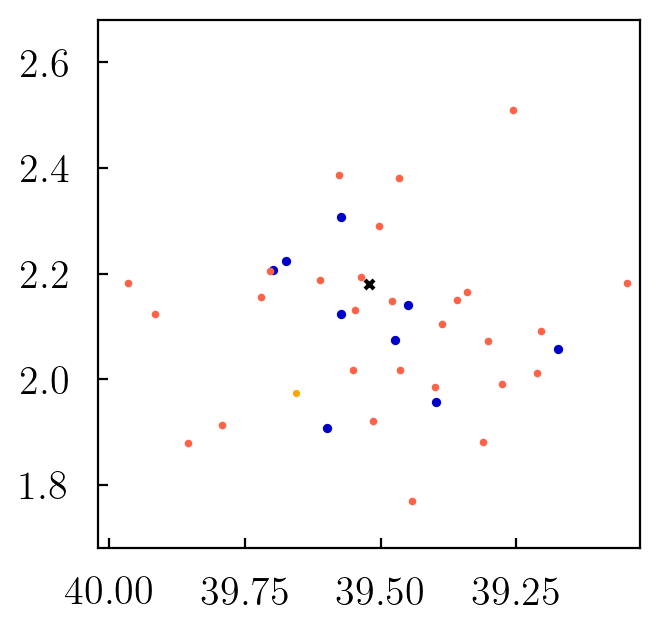

In [577]:
plt.figure(figsize = (3.5,3.5))


plt.scatter(ra_c, dec_c, c='k', s=10.5, marker='x', label='$5\sigma$ maximum')
plt.scatter(ra_Abell_box, dec_Abell_box, c='darkred', marker='^', s=4.5, label='Abell')
plt.scatter(ra_Reflex_box, dec_Reflex_box, c='g', s=2.5, label='Refelx')
plt.scatter(ra_NGC_box, dec_NGC_box, c='mediumblue', s=5.5, label='NGC')
plt.scatter(ra_2Mass_box, dec_2Mass_box, c='orange', s=2.5, label='2mass ')
plt.scatter(ra_LSBG, dec_LSBG, c='tomato', s=3)
#plt.legend(loc='upper right', frameon=True, fontsize=8)
plt.xlim(ra_max,ra_min);plt.ylim(dec_min,dec_max)
plt.show()

In [578]:
print(ra_c,dec_c)
print(name_Abell_box)
print(name_Reflex_box)
print(name_NGC_box)
print(name_2Mass_box)
print(ra_2Mass_box)
print(dec_2Mass_box)

(39.52169076751947, 2.1804511278195378)
[]
[]
[ 993 1004 1007 1008 1009 1016 1019 1020 1021]
[200052]
[39.6552]
[1.9749]


### Create a catalog

In [32]:
# Find the most prominent peaks
peaks = np.zeros([88,2])
peaks[:,0] = dec_5s;peaks[:,1] = ra_5s
Z_peaks = np.exp(kde.score_samples(np.radians(peaks)))

In [33]:
sort_indx = np.argsort(Z_peaks)
sort_indx = sort_indx[::-1]
print(sort_indx)

[76 50 40 23 87 38 84 37 21 86 59  0  6 77  7 14 69 45 47 51 42 20 10 56
 12 79 33 61 13  5 46 63 81 82 11 15  8 44  2 36 16 28 19 74 85 31 75 55
 26 54 34 67 66  1  3  4 65 80 27 73 52 64 48 57 60 35 30 83 70 39 78 17
 53 41 71 22 25 43 18 68 24  9 32 49 29 58 62 72]


In [34]:
print(ra_5s[40],dec_5s[40])

(18.49833147942158, -31.704260651629077)


### Number of LSBGs withing 0.5 deg from each one of the maxima

Now I want to find the number of LSBGs that lie withing 0.5 degrees (as calculated using the astropy distance) from each one of the 5sigma maxima.

In [35]:
from astropy import units as u
from astropy.coordinates import SkyCoord
# Create a catalog for the LSBG galaxies
C_LSBGs = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
n_maxima = 88 #Number of maxima
num_LSBGs = np.zeros(n_maxima, dtype=int)#Empty array 

max_sep = 0.5 #Separation to keep, in degrees

for i in range(n_maxima):
    # The coordinates of the i-th peak
    ra_loc = ra_5s[i]
    dec_loc = dec_5s[i]
    # Define an object for the position of the i-th maximum 
    C_loc = SkyCoord(ra=ra_loc*u.degree, dec=dec_loc*u.degree, frame='icrs')
    # ======================================================================
    # ======================================================================
    # Get the separation between this maximum and the objects in the LSBGs catalog
    sep_LSBGs = C_LSBGs.separation(C_loc).deg
    
    # Now keep objects that are within the separation limit
    ra_loc = ra[sep_LSBGs<max_sep]
    
    num_LSBGs[i] = len(ra_loc)
    
    
# ==============================================================================
# ==============================================================================

In [36]:
num_sort = num_LSBGs[sort_indx]
print(num_sort)

[65 45 41 39 39 32 34 27 30 28 30 25 29 28 26 25 22 25 26 24 21 20 22 21
 24 20 16 18 21 17 18 18 17 16 16 18 24 16 18 18 16 14 17 19 14 17 17 14
 15 16 18 17 15 16 14 16 17 15 17 13 16 16 16 13 15 17 14 18 14 12 16 14
 14 14 14 13 12 13 14 13 11 13 14 14 12 12 13 10]


In [37]:
ra_indx = ra_5s[sort_indx];dec_indx = dec_5s[sort_indx]

for i in range(10):
    print ra_indx[i], ',', dec_indx[i]

21.50166852057842 , -1.4285714285714306
54.938820912124584 , -18.471177944862156
18.49833147942158 , -31.704260651629077
17.49721913236931 , -45.93984962406015
9.888765294771972 , 3.1829573934837043
53.93770856507231 , -35.31328320802005
21.50166852057842 , 1.9799498746867101
55.339265850945495 , -35.51378446115288
16.896551724137936 , -46.74185463659148
39.52169076751947 , 2.1804511278195378


In [409]:
Association_names = ['No association','No association','Abell 3266','Abell S524','Abell 3667',
                     'Abell 2731','Abell 2806','No association','Abell S377','NGC 6854','Abell S463',
                    'Abell S861','Abell 3716','2Mass 200104','NGC 7196','No association','NGC 6987',
                    'NGC 7041','NGC 7144','No association','Abell S924','Abell 2870',
                     'No association','Abell 2877','No association','Abell 3747','2Mass 200194',
                    '2Mass 200531','2Mass 200476','Abell S1111','Abell S540','Abell 3376','Abell 3301',
                    'Abell 2911','No association','NGC 1316','2Mass 200185','Abell S373',
                    'Abell S373','No association','Abell S141','Abell 3341','Abell S301',
                    'Abell S536','RXC J0542.1-2607','RXC J0548.6-2527','Abell 2964','NGC 1401',
                    'Abell 533','NGC 1521','RXC J0340.1-1835','RXC J0454.8-1806','Abell S273','NGC 1091',
                    'RXC J0108.9-1537','No association','No association','RXC J0152.9-1345',
                    'NGC 1162','NGC 1200','2Mass 200145','2Mass 200462','2Mass 200311',
                    'NGC 1208','RXC J0137.2-0912','NGC 707','NGC 1069','NGC 829','No association',
                    '2Mass 200153','NGC 883','No association','NGC 145','RXC J2347.4-0218',
                    '2Mass 200078','NGC 227','Abell 194','Abell 119','No association',
                    'RXC J0252.8-0116','No association','2Mass 200530','Abell 168','NGC 7396',
                    'RXC J0125.5+0145','No association','2Mass 200052','NGC 199']

In [39]:
Assoc_names_array = np.asarray(Association_names)
Assoc_names_array_sort = Assoc_names_array[sort_indx]
print(Assoc_names_array_sort)

['Abell 194' 'RXC J0340.1-1835' 'Abell S141' 'Abell 2877' 'NGC 199'
 'Abell S373' 'RXC J0125.5+0145' 'Abell S373' 'Abell 2870' '2Mass 200052'
 'NGC 1200' 'No association' 'Abell 2806' 'Abell 119' 'No association'
 'Abell S989' '2Mass 200153' 'RXC J0548.6-2527' 'NGC 1401'
 'RXC J0454.8-1806' 'Abell S301' 'Abell S924' 'Abell S463'
 'No association' 'Abell 3716' 'RXC J0252.8-0116' 'Abell 2911'
 '2Mass 200462' '2Mass 200104' 'Abell 2731' 'Abell 2964' 'NGC 1208'
 '2Mass 200530' 'Abell 168' 'Abell S861' 'No association' 'Abell S377'
 'RXC J0542.1-2607' 'Abell 3266' '2Mass 200185' 'NGC 6987' '2Mass 200476'
 'No association' '2Mass 200078' 'No association' 'Abell 3376' 'NGC 227'
 'No association' '2Mass 200194' 'RXC J0108.9-1537' 'No association'
 'NGC 829' 'NGC 1069' 'No association' 'Abell S524' 'Abell 3667' 'NGC 707'
 'No association' '2Mass 200531' 'RXC J2347.4-0218' 'Abell S273'
 'RXC J0137.2-0912' 'Abell 533' 'RXC J1052.9-1345' '2Mass 200145'
 'NGC 1316' 'Abell S540' 'NGC 7396' 'NGC 883'

In [40]:
indices = np.arange(0,88)
print(indices[Assoc_names_array=='No association'])

[ 0  1  7 15 19 22 24 34 39 55 56 68 71 78 80 85]


In [41]:
lal = 15
print(ra_5s[lal],dec_5s[lal])

(-50.978865406006676, -49.3483709273183)


In [42]:
are_bad = [0,19,22,24,55,56,80,85]
are_good = [1,7,15,34,39,68,71,78]

### Construct the file with the properties of the associations

In [65]:
# Initialize arrays
# ===============================
#ra_assoc = np.zeros(88) # RA of the association
#dec_assoc = np.zeros(88) # DEC of the association
#name_assoc = ["" for x in range(88)] # Name of the association
#redshift = np.zeros(88) # Redshift of the association 
#dist = np.zeros(88) # Distance in Mpc
#disterr = np.zeros(88) # Error in Distance
#Qual = ["" for x in range(88)] #Quality of the association

In [582]:
i= 87
print(Association_names[i])

NGC 199


In [583]:
ra_assoc[i] = 9.888208
dec_assoc[i] = 3.138528
redshift[i] = 0.01535
dist[i] = 62.81
disterr[i] = 4.41
Qual[i] = 'II'

In [590]:
print(Qual)


['III', 'I', 'II', 'II', 'II', 'I', 'II', 'I', 'II', 'III', 'I', 'II', 'I', 'III', 'II', 'I', 'I', 'II', 'II', 'III', 'I', 'I', 'III', 'I', 'III', 'I', 'II', 'II', 'II', 'II', 'III', 'I', 'I', 'II', 'I', 'II', 'II', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'II', 'I', 'II', 'II', 'I', 'I', 'I', 'II', 'II', 'II', 'II', 'III', 'III', 'II', 'II', 'II', 'I', 'II', 'I', 'II', 'I', 'I', 'II', 'II', 'I', 'I', 'II', 'I', 'I', 'I', 'II', 'III', 'I', 'I', 'I', 'I', 'III', 'III', 'I', 'II', 'I', 'III', 'II', 'II']


In [612]:
#twomass_cat = fits.open('2Mass.fit')
#print twomass_cat[1].header.keys
sort_indx_1 = np.copy(sort_indx)
sort_indx_1[3] = sort_indx[4]
sort_indx_1[4] = sort_indx[3]
sort_indx_1[9] = sort_indx[10]
sort_indx_1[10] = sort_indx[9]

Now put everything in order - sort them

In [613]:
# Peak number
peak_number = np.arange(1,89)
# ================================
# RA and DEC of peaks
ra_peak = ra_5s[sort_indx_1]
dec_peak = dec_5s[sort_indx_1]
# ================================
# Name of the associations
best_assoc = Assoc_names_array[sort_indx_1]
# ================================
# RA and DEC of the associations
ra_ass = ra_assoc[sort_indx_1]
dec_ass = dec_assoc[sort_indx_1]
# ================================
# Redshift of the association
z_assoc = redshift[sort_indx_1]
# ================================
# Distance to the association and error
dist_assoc = dist[sort_indx_1]
err_dist = dist[sort_indx_1]
# ================================
# number of galaxies around 0.5 degrees
n_05 = num_LSBGs[sort_indx_1]
# ================================
# Quality
qualitino = np.asarray(Qual)
quality = qualitino[sort_indx_1]

In [614]:
print(best_assoc)

['Abell 194' 'RXC J0340.1-1835' 'Abell S141' 'NGC 199' 'Abell 2877'
 'Abell S373' 'RXC J0125.5+0145' 'Abell S373' 'Abell 2870' 'NGC 1200'
 '2Mass 200052' 'No association' 'Abell 2806' 'Abell 119' 'No association'
 'Abell S989' '2Mass 200153' 'RXC J0548.6-2527' 'NGC 1401'
 'RXC J0454.8-1806' 'Abell S301' 'Abell S924' 'Abell S463'
 'No association' 'Abell 3716' 'RXC J0252.8-0116' 'Abell 2911'
 '2Mass 200462' '2Mass 200104' 'Abell 2731' 'Abell 2964' 'NGC 1208'
 '2Mass 200530' 'Abell 168' 'Abell S861' 'No association' 'Abell S377'
 'RXC J0542.1-2607' 'Abell 3266' '2Mass 200185' 'NGC 6987' '2Mass 200476'
 'No association' '2Mass 200078' 'No association' 'Abell 3376' 'NGC 227'
 'No association' '2Mass 200194' 'RXC J0108.9-1537' 'No association'
 'NGC 829' 'NGC 1069' 'No association' 'Abell S524' 'Abell 3667' 'NGC 707'
 'No association' '2Mass 200531' 'RXC J2347.4-0218' 'Abell S273'
 'RXC J0137.2-0912' 'Abell 533' 'RXC J1052.9-1345' '2Mass 200145'
 'NGC 1316' 'Abell S540' 'NGC 7396' 'NGC 883'

In [615]:
import pandas as pd
from collections import OrderedDict

In [618]:
peak_df = pd.DataFrame( OrderedDict(( 
    ('peak_number', pd.Series(peak_number)),
    ('ra_peak', pd.Series(ra_peak)),
    ('dec_peak', pd.Series(dec_peak)),
    ('best_assoc',pd.Series(best_assoc)), 
    ('ra_assoc', pd.Series(ra_ass)),
    ('dec_assoc', pd.Series(ra_ass)),
    ('z_assoc', pd.Series(z_assoc)),
    ('dist_assoc', pd.Series(dist_assoc)),
    ('err_dist', pd.Series(err_dist)),
    ('n_05', pd.Series(n_05)),
    ('quality', pd.Series(quality))
)))

In [619]:
peak_df.head()

,peak_number,ra_peak,dec_peak,best_assoc,ra_assoc,dec_assoc,z_assoc,dist_assoc,err_dist,n_05,quality
0,1,21.501669,-1.428571,Abell 194,21.420000,21.420000,0.01800,75.07,75.07,65,I
1,2,54.938821,-18.471178,RXC J0340.1-1835,55.047500,55.047500,0.00570,23.41,23.41,45,I
2,3,18.498331,-31.704261,Abell S141,18.475833,18.475833,0.02000,84.80,84.80,41,I
3,4,9.888765,3.182957,NGC 199,9.888208,9.888208,0.01535,62.81,62.81,39,II
4,5,17.497219,-45.939850,Abell 2877,17.501667,17.501667,0.02470,106.41,106.41,39,I


In [622]:
#peak_df.to_csv('peaks_associations.csv')